In [ ]:
%conda install pandas numpy scikit-learn matplotlib

import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, RFE, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold

def get_dataset():
    data = pd.read_csv('data/cleveland.csv')
    X = data.drop('num', axis=1)
    y = data['num'].apply(lambda x: 1 if x > 0 else 0)
    
    X = X.replace('?', np.nan).astype(float)
    X = X.fillna(X.mean())
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X, y.values

def feature_selection(X, selected_features):
    return X[selected_features]

In [ ]:
# Retrieve the model
def get_model():
    return LogisticRegression(max_iter=1000)

# def evaluate_model(cv):
#     X, y = get_dataset()
#     model = get_model()
#     scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#     return np.mean(scores), scores.min(), scores.max()

def evaluate_model(X, y, cv):
    model = get_model()
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return np.mean(scores), scores.min(), scores.max()

X, y = get_dataset()

ideal_features = ['cp', 'slope', 'chol', 'age', 'restecg', 'sex', 'fbs', 'exang']
X_selected = feature_selection(X, ideal_features)

# Evaluate using leave-one-out cross-validation
# ideal, _, _ = evaluate_model(X_selected, y, LeaveOneOut())
ideal, _, _ = evaluate_model(X, y, LeaveOneOut())
print('Ideal: %.3f' % ideal)

# Define folds to test, test from 2 to 20 folds
folds = range(2, 21)

# Perform k-fold cross-validation analysis
means, mins, maxs = [], [], []

for k in folds:
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
    k_mean, k_min, k_max = evaluate_model(X, y, cv)
    print(f'> folds={k}, accuracy={k_mean:.3f} ({k_min:.3f},{k_max:.3f})')
    means.append(k_mean)
    mins.append(k_mean - k_min)
    maxs.append(k_max - k_mean)


# Line plot of k mean values with min/max error bars
pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
pyplot.plot(folds, [ideal for _ in range(len(folds))], color='r')
pyplot.xlabel('Number of Folds')
pyplot.ylabel('Accuracy')
pyplot.show()

In [ ]:
# Example from: https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

# sensitivity analysis of k in k-fold cross-validation
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

# create the dataset
def get_dataset(n_samples=100):
	X, y = make_classification(n_samples=n_samples, n_features=20, n_informative=15, n_redundant=5, random_state=1)
	return X, y

# retrieve the model to be evaluate
def get_model():
	model = LogisticRegression()
	return model

# evaluate the model using a given test condition
def evaluate_model(cv):
	# get the dataset
	X, y = get_dataset()
	# get the model
	model = get_model()
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	# return scores
	return mean(scores), scores.min(), scores.max()

# calculate the ideal test condition
ideal, _, _ = evaluate_model(LeaveOneOut())
print('Ideal: %.3f' % ideal)
# define folds to test
folds = range(2,31)
# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()
# evaluate each k value
for k in folds:
	# define the test condition
	cv = KFold(n_splits=k, shuffle=True, random_state=1)
	# evaluate k value
	k_mean, k_min, k_max = evaluate_model(cv)
	# report performance
	print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
	# store mean accuracy
	means.append(k_mean)
	# store min and max relative to the mean
	mins.append(k_mean - k_min)
	maxs.append(k_max - k_mean)
# line plot of k mean values with min/max error bars
pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
pyplot.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
pyplot.show()

In [195]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import LeaveOneOut

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, message="A single label was found in 'y_true' and 'y_pred'.")
warnings.filterwarnings("ignore", category=UserWarning, message="y_pred contains classes not in y_true")
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


In [196]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    X = data.drop('num', axis=1)
    y = data['num'].apply(lambda x: 1 if x > 0 else 0)  # Convert to binary classification
    
    X = X.replace('?', np.nan).astype(float)
    X = X.fillna(X.mean())
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X, y

In [197]:
def select_features(X, y, k, method='univariate'):
    if method == 'univariate':
        selector = SelectKBest(f_classif, k=k)
    elif method == 'mutual_info':
        selector = SelectKBest(mutual_info_classif, k=k)
    elif method == 'rfe':
        selector = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=k)
    elif method == 'random_forest':
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, y)
        importances = rf.feature_importances_
        indices = np.argsort(importances)[::-1]
        return X.columns[indices[:k]].tolist()
    else:
        raise ValueError("Invalid method. Choose 'univariate', 'mutual_info', 'rfe', or 'random_forest'.")
    
    selector.fit(X, y)
    return X.columns[selector.get_support()].tolist()

In [198]:
def get_model():
    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    return LogisticRegression(max_iter=1000)

def perform_grid_search(X, y):
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
    
    grid_search = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1
    )
    
    grid_search.fit(X, y)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)
    
    return grid_search.best_estimator_

def evaluate_model(X, y, cv):
    model = get_model()
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
    return np.mean(scores), scores.min(), scores.max()

def safe_balanced_accuracy(y_true, y_pred):
    try:
        return balanced_accuracy_score(y_true, y_pred)
    except ValueError:
        return float(y_true[0] == y_pred[0])

def evaluate_model_loocv(X, y, model):
    loo = LeaveOneOut()
    scores = []
    n_samples = X.shape[0]
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        score = safe_balanced_accuracy(y_test, y_pred)
        scores.append(score)
        
        if (len(scores) % 50 == 0) or (len(scores) == n_samples):
            print(f"Processed {len(scores)}/{n_samples} samples. Current average score: {np.mean(scores):.3f}")
    
    return np.mean(scores)


In [199]:
def evaluate_model_with_feature_selection(X, y, k, method='univariate', n_splits=10, model=None):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        selected_features = select_features(X_train, y_train, k, method)
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        
        if model is None:
            model = get_model()
        
        model.fit(X_train_selected, y_train)
        
        y_pred = model.predict(X_test_selected)
        
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
    
    return precision_scores, recall_scores, f1_scores, selected_features

In [200]:
def compare_feature_selection_methods(X, y, methods, k_range, model):
    results = {}
    for method in methods:
        method_results = []
        for k in k_range:
            _, _, f1_scores, _ = evaluate_model_with_feature_selection(X, y, k, method, model=model)
            method_results.append(np.mean(f1_scores))
        results[method] = method_results
    return results

In [201]:
def predict_challenge_dataset(challenge_file, original_file, best_k, best_method, best_model):
    X_original, y_original = load_and_preprocess_data(original_file)
    X_challenge, _ = load_and_preprocess_data(challenge_file)
    
    best_features = select_features(X_original, y_original, best_k, best_method)
    X_original_selected = X_original[best_features]
    X_challenge_selected = X_challenge[best_features]
    
    best_model.fit(X_original_selected, y_original)
    
    y_pred = best_model.predict(X_challenge_selected)
    return y_pred

def evaluate_challenge_dataset(challenge_file, original_file, best_k, best_method, best_model):
    X_challenge, y_true = load_and_preprocess_data(challenge_file)
    y_pred = predict_challenge_dataset(challenge_file, original_file, best_k, best_method, best_model)
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print("\nChallenge Dataset Results:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    
    return y_pred


Performing grid search...
Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.8307630714095531
Calculating ideal test condition...
Processed 50/303 samples. Current average score: 0.840


/home/matt/projects/project4-knn-cs5830/.conda/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/matt/projects/project4-knn-cs5830/.conda/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/matt/projects/project4-knn-cs5830/.conda/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to

Processed 100/303 samples. Current average score: 0.840
Processed 150/303 samples. Current average score: 0.853
Processed 200/303 samples. Current average score: 0.840
Processed 250/303 samples. Current average score: 0.852
Processed 300/303 samples. Current average score: 0.843
Processed 303/303 samples. Current average score: 0.842
Ideal (Leave-One-Out): 0.842
Comparing feature selection methods...


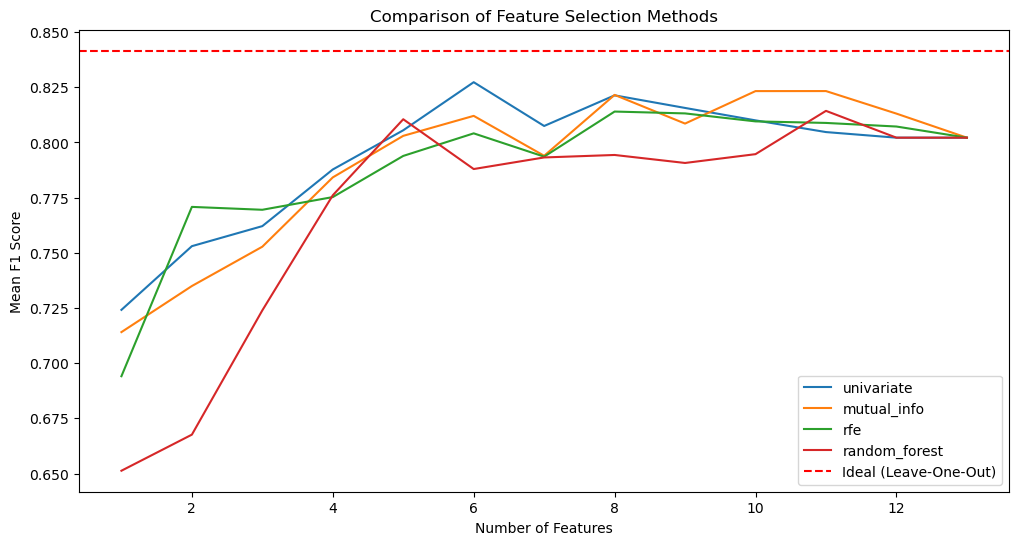

Best method: univariate
Best number of features: 6

Final Results:
Precision scores: [1.0, 0.9230769230769231, 0.75, 0.9166666666666666, 0.9090909090909091, 0.7333333333333333, 0.8, 1.0, 0.8888888888888888, 0.9090909090909091]
Recall scores: [0.9444444444444444, 0.8571428571428571, 0.6923076923076923, 0.8461538461538461, 0.6666666666666666, 1.0, 0.6666666666666666, 0.7777777777777778, 0.6666666666666666, 0.7692307692307693]
F1 scores: [0.9714285714285714, 0.8888888888888888, 0.72, 0.88, 0.7692307692307693, 0.8461538461538461, 0.7272727272727273, 0.875, 0.7619047619047619, 0.8333333333333334]
Mean F1 score: 0.827
Best features: ['cp', 'thalach', 'exang', 'oldpeak', 'ca', 'thal']


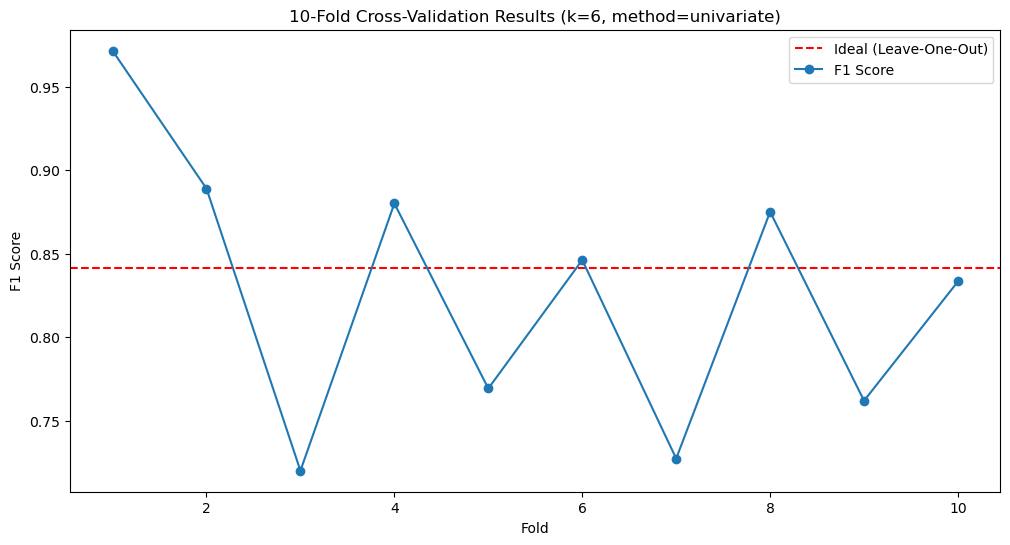


Evaluating Challenge Dataset:

Challenge Dataset Results:
Precision: 0.938
Recall: 0.833
F1 Score: 0.882


In [202]:
def main():
    original_file = 'data/cleveland.csv'
    challenge_file = 'data/cleveland-test-sample.csv'
    X, y = load_and_preprocess_data(original_file)
    
    # Perform grid search
    print("Performing grid search...")
    best_model = perform_grid_search(X, y)
    
    # Calculate the ideal test condition using Leave-One-Out
    print("Calculating ideal test condition...")
    ideal = evaluate_model_loocv(X, y, best_model)
    print('Ideal (Leave-One-Out): %.3f' % ideal)
    
    # Compare different feature selection methods
    methods = ['univariate', 'mutual_info', 'rfe', 'random_forest']
    k_range = range(1, len(X.columns) + 1)
    print("Comparing feature selection methods...")
    results = compare_feature_selection_methods(X, y, methods, k_range, best_model)
    
    # Plot comparison of feature selection methods
    plt.figure(figsize=(12, 6))
    for method in methods:
        plt.plot(k_range, results[method], label=method)
    plt.axhline(y=ideal, color='r', linestyle='--', label='Ideal (Leave-One-Out)')
    plt.xlabel('Number of Features')
    plt.ylabel('Mean F1 Score')
    plt.title('Comparison of Feature Selection Methods')
    plt.legend()
    plt.show()
    
    # Find best method and k
    best_method = max(results, key=lambda x: max(results[x]))
    best_k = k_range[np.argmax(results[best_method])]
    print(f"Best method: {best_method}")
    print(f"Best number of features: {best_k}")
    
    # Evaluate with best method and k
    precision_scores, recall_scores, f1_scores, best_features = evaluate_model_with_feature_selection(X, y, best_k, best_method, model=best_model)
    
    print("\nFinal Results:")
    print(f"Precision scores: {precision_scores}")
    print(f"Recall scores: {recall_scores}")
    print(f"F1 scores: {f1_scores}")
    print(f"Mean F1 score: {np.mean(f1_scores):.3f}")
    print(f"Best features: {best_features}")
    
    # Plot k-fold cross-validation results
    folds = range(1, 11)
    plt.figure(figsize=(12, 6))
    plt.errorbar(folds, f1_scores, fmt='o-', label='F1 Score')
    plt.axhline(y=ideal, color='r', linestyle='--', label='Ideal (Leave-One-Out)')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.title(f'10-Fold Cross-Validation Results (k={best_k}, method={best_method})')
    plt.legend()
    plt.show()
    
    # Evaluate Challenge Dataset
    print("\nEvaluating Challenge Dataset:")
    challenge_predictions = evaluate_challenge_dataset(challenge_file, original_file, best_k, best_method, best_model)
    
    # If you want to save the predictions
    # pd.DataFrame(challenge_predictions, columns=['Prediction']).to_csv('challenge_predictions.csv', index=False)

if __name__ == "__main__":
    main()

Interesting. After tuning the logistic model with a grid search the better feature selection model is Univariate (was random_forest), while also reducing the selected features from 11 to 6. We select k=6 based on the recommendation from our example source:

```
A line plot is created comparing the mean accuracy scores to the LOOCV result with the min and max of each result distribution indicated using error bars.

The results suggest that for this model on this dataset, most k values underestimate the performance of the model compared to the ideal case. The results suggest that perhaps k=10 alone is slightly optimistic and perhaps k=13 might be a more accurate estimate.
```

We utilize the same method of plotting our 10-fold CV results for each tested k value, and find that a k of 6 represents a near ideal score. 

#### More information on feature selection method:

- Univariate Selection (f_classif):
    - Selects the best features based on univariate statistical tests. For classification tasks, it uses the ANOVA F-value between each feature and the target. Fast and scalable but doesn't account for feature interactions.
- Mutual Information (mutual_info_classif):
    - This method measures the mutual dependence between two variables. It can capture non-linear relationships between features and the target, which linear correlation measures might miss.
- Recursive Feature Elimination (RFE):
    - RFE works by recursively removing attributes and building a model on those attributes that remain. It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.
- Random Forest Feature Importance:
    - Uses the Random Forest algorithm to compute feature importance. Optimizes based on how much each feature decreases the weighted impurity in a tree.

Multiple methods for feature selection:

- Different perspectives: Each method looks at the data from a different angle. For example, univariate methods consider each feature independently, while RFE considers feature interactions.
- Robustness: By using multiple methods, we can be more confident in our feature selection. If a feature is selected by multiple methods, it's likely to be truly important.
- Handling different relationships: Some methods (like mutual information) can capture non-linear relationships, while others (like univariate selection) are better for linear relationships.
- Complementary information: Each method might identify different important features, giving us a more comprehensive view of what's important in our dataset.
- Model-specific vs. Model-agnostic: Some methods (like RFE) are model-specific, while others (like univariate selection) are model-agnostic. Using both types can provide more robust results.

For each method, after a grid search for optimal parameters on the whole dataset:

- Apply each method for different numbers of features (k)
- For each method and k, we perform cross-validation using logistic regression
- Calculate the mean F1 score for each method and k
- Plot the results to visually compare the methods